In [2]:
%reload_ext autoreload
%autoreload 2

import pickle

from utils.utils import split_csv

from preprocessing.cleaning import get_cleaned_data
from preprocessing.encoding import encode_data

from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from exploration.midterm_exploration import plot_feature_against_diagnosis

from modeling.mrmr_feature_selection import plot_cutoffs
from modeling.logistic import run_elastic_net, evaluate_results
from modeling.RandomForest import run_random_forest, evaluate_random_forest
from modeling.mlp import run_mlp, evaluate_mlp
from modeling.comparisons import plot_f1_scores

## Constants for the label

In [3]:
LABEL = "P1_PT_TYPE"
AD = 1
CN = 2
MCI = 4

## Clean, encode, and partition the data into blood, clinical, and combined dataframes

In [ ]:
df = encode_data(get_cleaned_data())
combined, blood_only, clinical_only_mci = split_csv(df)
clinical_only = clinical_only_mci[clinical_only_mci[LABEL] != MCI]

## Plot some initial exploratory visualizations

In [ ]:
plot_labels_pie_chart(df)

In [ ]:
plot_blood_draw_statistics(df)

In [ ]:
plot_correlations(df)

In [ ]:
plot_feature_against_diagnosis(
    blood_only,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png="Total Tau Concentration by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical_only,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png="WMSR Digit Span Score by Diagnosis"
)

## Run MRMR feature selection to pick features for each of the partitions

In [ ]:
blood_features, clinical_features, combined_features = plot_cutoffs(blood_only, clinical_only, combined)
blood_only_subset = blood_only[blood_features + [LABEL]]
clinical_only_subset = clinical_only[clinical_features + [LABEL]]
combined_subset = combined[combined_features + [LABEL]]
clinical_only_subset_mci = clinical_only_mci[clinical_features + [LABEL]]

## Run logistic regression on the entire feature set

In [ ]:
run_elastic_net(blood_only, num_iters=20, pickle="Blood Only LR")
blood_lr = evaluate_results("Blood Only LR")

In [ ]:
run_elastic_net(clinical_only, num_iters=20, pickle="Clinical Only LR")
clinical_lr = evaluate_results("Clinical Only LR")

In [ ]:
run_elastic_net(combined, num_iters=20, pickle="Combined LR")
combined_lr = evaluate_results("Combined LR")

## Run logistic regression on the features selected by MRMR

In [ ]:
run_elastic_net(blood_only_subset, num_iters=20, pickle="Blood Only LR with MRMR")
blood_lr_mrmr = evaluate_results("Blood Only LR with MRMR")

In [ ]:
run_elastic_net(clinical_only_subset, num_iters=20, pickle="Clinical Only LR with MRMR")
clinical_lr_mrmr = evaluate_results("Clinical Only LR with MRMR")

In [ ]:
run_elastic_net(combined_subset, num_iters=20, pickle="Combined LR with MRMR")
combined_lr_mrmr = evaluate_results("Combined LR with MRMR")

## Run random forest

In [ ]:
run_random_forest(blood_only, num_iters=20, pickle="Blood Only RF", blood=True)
blood_rf = evaluate_random_forest("Blood Only RF")

In [ ]:
run_random_forest(clinical_only, num_iters=20, pickle="Clinical Only RF")
clinical_rf = evaluate_random_forest("Clinical Only RF")

In [ ]:
run_random_forest(combined, num_iters=20, pickle="Combined RF")
combined_rf = evaluate_random_forest("Combined RF")

## Run MLP on the entire feature set

In [ ]:
run_mlp(blood_only, num_iters=20, pickle="Blood Only MLP")
blood_mlp = evaluate_mlp("Blood Only MLP")

In [ ]:
run_mlp(clinical_only, num_iters=20, pickle="Clinical Only MLP")
clinical_mlp = evaluate_mlp("Clinical Only MLP")

In [ ]:
run_mlp(combined, num_iters=20, pickle="Combined MLP")
combined_mlp = evaluate_mlp("Combined MLP")

## Run MLP on the features selected by MRMR

In [ ]:
run_mlp(blood_only_subset, num_iters=20, pickle="Blood Only MLP with MRMR")
blood_mlp_mrmr = evaluate_mlp("Blood Only MLP with MRMR")

In [ ]:
run_mlp(clinical_only_subset, num_iters=20, pickle="Clinical Only MLP with MRMR")
clinical_mlp_mrmr = evaluate_mlp("Clinical Only MLP with MRMR")

In [ ]:
run_mlp(combined_subset, num_iters=20, pickle="Combined MLP with MRMR")
combined_mlp_mrmr = evaluate_mlp("Combined MLP with MRMR")

## Store the model results

In [ ]:
model_results = {
    "blood_lr": blood_lr,
    "clinical_lr": clinical_lr,
    "combined_lr": combined_lr,
    "blood_lr_mrmr": blood_lr_mrmr,
    "clinical_lr_mrmr": clinical_lr_mrmr,
    "combined_lr_mrmr": combined_lr_mrmr,
    "blood_rf": blood_rf,
    "clinical_rf": clinical_rf,
    "combined_rf": combined_rf,
    "blood_mlp": blood_mlp,
    "clinical_mlp": clinical_mlp_mrmr,
    "combined_mlp": combined_mlp,
    "blood_mlp_mrmr": blood_mlp_mrmr,
    "clinical_mlp_mrmr": clinical_mlp_mrmr,
    "combined_mlp_mrmr": combined_mlp_mrmr
}

with open("Model Results.pickle", "wb") as handle:
    pickle.dump(model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Read in the cached model results

In [5]:
with open("Model Results.pickle", "rb") as handle:
    results = pickle.load(handle)

## Compare models

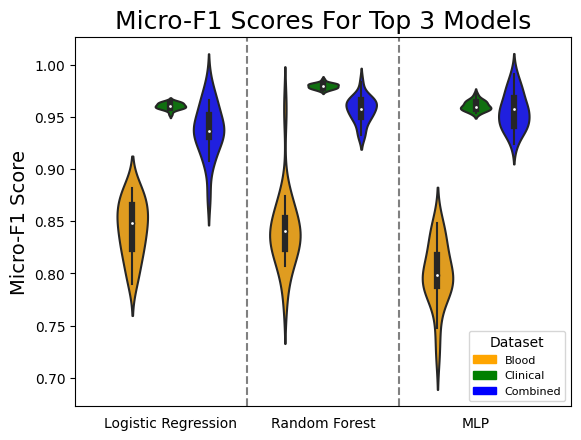

In [6]:
plot_f1_scores(
    [
        results["blood_lr_mrmr"]["f1"],
        results["clinical_lr_mrmr"]["f1"],
        results["combined_lr_mrmr"]["f1"],
        results["blood_rf"]["f1"],
        results["clinical_rf"]["f1"],
        results["combined_rf"]["f1"],
        results["blood_mlp_mrmr"]["f1"],
        results["clinical_mlp_mrmr"]["f1"],
        results["combined_mlp_mrmr"]["f1"],
    ],
    title="Micro-F1 Scores For Top 3 Models",
    ylabel="Micro-F1 Score",
    models=["Logistic Regression", "Random Forest", "MLP"],
    pad=3
)

In [ ]:
run_elastic_net(clinical_only_mci, num_iters=20, pickle="Clinical LR with MCI")
clinical_lr_mci = evaluate_results("Clinical LR with MCI")

In [ ]:
run_elastic_net(clinical_only_subset_mci, num_iters=20, pickle="Clinical LR with MCI and MRMR")
clinical_lr_mci_mrmr = evaluate_results("Clinical LR with MCI and MRMR")